In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
from skimage import io, filters
import numpy as np

from tqdm.notebook import tqdm

import cv2
import copy
import time

from mpire import WorkerPool
from StereoFractAnalyzer import StereoFractAnalyzer

from PIL import Image
from matplotlib import cm

# from combra.stats.preprocess import stats_preprocess

from combra import stats as combra_stats

In [ ]:
# Set the path to your image folders
base_path = 'poliamid_clusters/data/images'
output_path = 'poliamid_clusters/combined_images.png'  # Path to save the output image

# Get all subdirectories (folders)
subfolders = [f.path for f in os.scandir(base_path) if f.is_dir()]

# Set up the plot
num_subfolders = len(subfolders)
plt.figure(figsize=(12, 3 * num_subfolders))  # Adjust figure size based on number of folders

for i, folder in enumerate(subfolders, 1):
    # Get all image files in the folder
    image_files = [f for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
    
    if len(image_files) < 2:
        print(f"Folder {folder} has less than 2 images. Skipping...")
        continue
    
    # Randomly select 2 images
    selected_images = random.sample(image_files, 2)
    
    # Plot the images
    for j, img_file in enumerate(selected_images, 1):
        img_path = os.path.join(folder, img_file)
        img = Image.open(img_path)
        
        plt.subplot(num_subfolders, 2, (i-1)*2 + j)
        plt.imshow(img)
        plt.title(f"Folder: {os.path.basename(folder)}\nImage: {img_file}")
        plt.axis('off')

plt.tight_layout()
plt.savefig(output_path, bbox_inches='tight', dpi=300)  # Save to file

In [ ]:
output_path = 'poliamid_clusters/combined_images.png'  

subfolders = [f.path for f in os.scandir(base_path) if f.is_dir()]
subfolders

In [ ]:
# image_path = 'poliamid_clusters/data/images/Полиамид 12   1 кадр в мин   (3-10-2024_18-11--6-46)/IMG_1259.JPG'
# image_path = 'poliamid_clusters/data/images/Полиамид 12   1 кадр в мин   (3-10-2024_18-11--6-46)/IMG_2266.JPG'
# image_path = 'poliamid_clusters/data/images/Полиамид 12   1 кадр в мин   (24-09-2024_12-27--1-0)/IMG_6186.JPG'
# image_path = 'poliamid_clusters/data/images/Полиамид 12   1 кадр в мин   (24-09-2024_12-27--1-0)/IMG_5589.JPG'
# image_path = 'poliamid_clusters/data/images/Полиамид 12   1 кадр в мин   (12-09-2024_12-26--1-3)/IMG_4097.JPG'
# image_path = 'poliamid_clusters/data/images/Полиамид 12   1 кадр в мин   (12-09-2024_12-26--1-3)/IMG_3603.JPG'
# image_path = 'poliamid_clusters/data/images/Полиамид 12   1 кадр в мин   (1-10-2024_14-6--2-40)/IMG_0585.JPG'
# image_path = 'poliamid_clusters/data/images/Полиамид 12   1 кадр в мин   (1-10-2024_14-6--2-40)/IMG_0268.JPG'
# image_path = 'poliamid_clusters/data/images/Полиамид 12   1 кадр в мин   (09-09-2024_12-10--0-44)/IMG_9009.JPG'
# image_path = 'poliamid_clusters/data/images/Полиамид 12   1 кадр в мин   (09-09-2024_12-10--0-44)/IMG_8955.JPG'
# image_path = 'poliamid_clusters/data/images/Полиамид 12   1 кадр в мин   (02-09-2024_13-33--2-7)/IMG_8747.JPG'
# image_path = 'poliamid_clusters/data/images/Полиамид 12   1 кадр в мин   (02-09-2024_13-33--2-7)/IMG_6932.JPG'

# img = io.imread(image_path)
# img = img[:,900:-900]

# original_img = original_img[500:-300,1200:-1500]
# original_img=original_img[:2000,:2000]

# plt.imshow(img)
# plt.show()

# Image preprocess

In [ ]:
image_path = 'poliamid_clusters/data/images/Полиамид 12   1 кадр в мин   (09-09-2024_12-10--0-44)/IMG_8955.JPG'
# image_path = 'poliamid_clusters/data/images/Полиамид 12   1 кадр в мин   (02-09-2024_13-33--2-7)/IMG_8747.JPG'


img = io.imread(image_path)
img = img[500:-300,1200:-1500]

img=img[:2000,:2000]
img[:250,:250]=np.full((250,250,3),20)

plt.imshow(img)
plt.show()

In [ ]:
images_paths=['images/0001.JPG',
              'images/0500.JPG',
              'images/1000.JPG',
              'images/1500.JPG',
              'images/2000.JPG',
              'images/2500.JPG',
              'images/3000.JPG',
              'images/3500.JPG',
              'images/4000.JPG',
            ]
img = io.imread(images_paths[2])
img = img[400:-400,1300:-1300]

print(img.shape)


thresh = filters.threshold_otsu(img)
binary = img > thresh  # Apply threshold
binary = binary*255


plt.imshow(binary)
plt.show()

In [ ]:

def find_contours(binary_image):
    """Find contours using OpenCV"""
    contours, _ = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def draw_contours(original_img, contours):
    """Draw contours on the original image"""
    contour_img = cv2.cvtColor(original_img, cv2.COLOR_GRAY2BGR)
    for contour in contours:
        color=(random.randint(0,255),random.randint(0,255),random.randint(0,255))
        cv2.drawContours(contour_img, contour, -1, color, 2)
    return contour_img

def add_text_upper_right(img, text, font_scale=1.0, thickness=2, color=(255, 255, 255), 
                         bg_color=(0, 0, 0), padding=10):
    """Add text to the upper right corner of the image"""
    # Get image dimensions
    h, w = img.shape[:2]
    
    # Set font
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    # Get text size
    (text_width, text_height), baseline = cv2.getTextSize(text, font, font_scale, thickness)
    
    # Calculate position (upper right corner)
    x = w - text_width - padding
    y = text_height + padding
    
    # Optional: Draw background rectangle for better visibility
    if bg_color is not None:
        cv2.rectangle(img, 
                     (x - padding//2, y - text_height - padding//2), 
                     (x + text_width + padding//2, y + baseline + padding//2), 
                     bg_color, -1)
    
    # Draw text
    cv2.putText(img, text, (x, y), font, font_scale, color, thickness, cv2.LINE_AA)
    
    return img

def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = img[400:-400,1300:-1300]
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)
    cnts = find_contours(binary)
    return binary, cnts

def plot_contours(img, contours, images_path):

    contour_img = draw_contours(img, contours)

    # 3. Add text to upper right corner
    text = f"{images_path.split('/')[-1]}"
    contour_img = add_text_upper_right(contour_img, text, font_scale=7.5, thickness=2, 
                                    color=(255, 255, 255), bg_color=(0, 0, 0), padding=10)

    # fig, axes = plt.subplots(1,2,figsize=(20,10))

    # axes[0].imshow(img, cmap='gray')
    # axes[1].imshow(contour_img)
    # axes[1].set_title(f'number of contours {len(contours)}')
    # cv2.imwrite(f'images/contours_{images_path.split("/")[-1]}', contour_img)

# Main processing
# image_path = 'poliamid_clusters/data/images/Полиамид 12   1 кадр в мин   (09-09-2024_12-10--0-44)/IMG_8955.JPG'
images_paths=['images/0005.JPG',
              'images/0500.JPG',
              'images/1000.JPG',
              'images/1500.JPG',
              'images/2000.JPG',
              'images/2500.JPG',
              'images/3000.JPG',
              'images/3500.JPG',
              'images/4000.JPG',
              'images/4321.JPG',
              ]

for image_path in images_paths:
    binary, cnts = preprocess_image(image_path)
    plot_contours(binary, cnts, image_path)


In [ ]:
%%time

images_paths=['images/0005.JPG',
              'images/0500.JPG',
              'images/1000.JPG',
              'images/1500.JPG',
              'images/2000.JPG',
              'images/2500.JPG',
              'images/3000.JPG',
              'images/3500.JPG',
              'images/4000.JPG',
              'images/4321.JPG',
              ]

legend=[]

step=1

for step in [1,2,3,4,5]:

    plt.figure(figsize=(10,7))

    for image_path in tqdm(images_paths):
        binary, cnts = preprocess_image(image_path)
        plot_contours(binary, cnts, image_path)

        len_list=[]

        for contour in cnts:
            len_list.append(len(contour))

        x, y = combra_stats.stats_preprocess(len_list, step)
        plt.plot(x, y, '-o')

        legend.append(f'{len(cnts)} contours {image_path.split("/")[-1]}')


    plt.legend(legend, loc='upper right',fontsize=15)
    plt.xlim(0,40)
    # plt.yscale('log')
    plt.xlabel('number of points in each contour ',fontsize=15)
    plt.ylabel('p(x)',fontsize=15)
    plt.title(f'contour sizes, step={step}',fontsize=15)

    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    plt.savefig(f'countour_lens_step={step}.jpg',bbox_inches='tight')

In [ ]:
%%time

images_paths=['images/0005.JPG',
              'images/0500.JPG',
              'images/1000.JPG',
              'images/1500.JPG',
              'images/2000.JPG',
              'images/2500.JPG',
              'images/3000.JPG',
              'images/3500.JPG',
              'images/4000.JPG',
              'images/4321.JPG',
              ]

legend=[]

for step in [1,2,3,4,5]:

    plt.figure(figsize=(10,7))


    for image_path in tqdm(images_paths):
        binary, cnts = preprocess_image(image_path)
        plot_contours(binary, cnts, image_path)

        area_list=[]

        for contour in cnts:
            area_list.append(cv2.contourArea(contour))

        x, y = combra_stats.stats_preprocess(area_list, step)
        plt.plot(x, y, '-o')

        legend.append(f'{len(cnts)} contours {image_path.split("/")[-1]}')


    plt.legend(legend, loc='upper right',fontsize=15)
    plt.xlim(0,40)
    # plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('area of contour, pixels',fontsize=15)
    plt.ylabel('p(x)',fontsize=15)
    plt.title(f'step={step}',fontsize=15)

    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    plt.savefig(f'countour_areas_step={step}.jpg',bbox_inches='tight')

    plt.show()

# Fractal dimention

In [ ]:
def process_contour(contour_idx):

    contour = contours[contour_idx]

    eps=3
    x_min,y_min=np.min(contour,axis=0)[0]

    cnt_new = copy.copy(contour)
    cnt_new[:,:,0]=np.int32(cnt_new[:,:,0]-x_min+eps)
    cnt_new[:,:,1]=np.int32(cnt_new[:,:,1]-y_min+eps)

    x_max,y_max=np.max(cnt_new,axis=0)[0]

    mask = np.zeros((x_max+eps,y_max+eps))
    cv2.drawContours(mask, [cnt_new], -1, 255, thickness=cv2.FILLED)

    analyzer = StereoFractAnalyzer()

    sizes, counts = analyzer.box_count_image(Image.fromarray(np.uint8(cm.gist_earth(mask)*255)))
    log_sizes = np.log(1/sizes)
    log_counts = np.log(counts)
    coeffs = np.polyfit(log_sizes, log_counts, 1)
    fractal_dimension = coeffs[0]

    return fractal_dimension


binary, contours = preprocess_image(images_paths[0])

# Prepare data
new_contours=[contour for contour in contours if len(contour)>2]

indices = list(range(len(new_contours)))

# Process in parallel - NO shared_objects
fds = []
with WorkerPool(n_jobs=10) as pool:
    results = pool.map(process_contour, indices, progress_bar=True)
    fds = [fd for fd in results if fd is not None]

In [ ]:
x, y = combra_stats.stats_preprocess(fds, 0.1)
plt.plot(x, y, '-o')

In [ ]:
plt.hist(fds,bins=50)
# plt.xlim(0,3)
plt.xlabel('fractal dimention')
plt.ylabel('count')
plt.title('Histogram of fractal dimension')
# plt.legend([f'{len(contours)} contours\n{images_path.split("/")[-1]}'],loc='upper right')
# plt.savefig(f'fractal_dimension_{images_path.split("/")[-1]}') 

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 919/919 [00:00<00:00, 1162.68it/s]


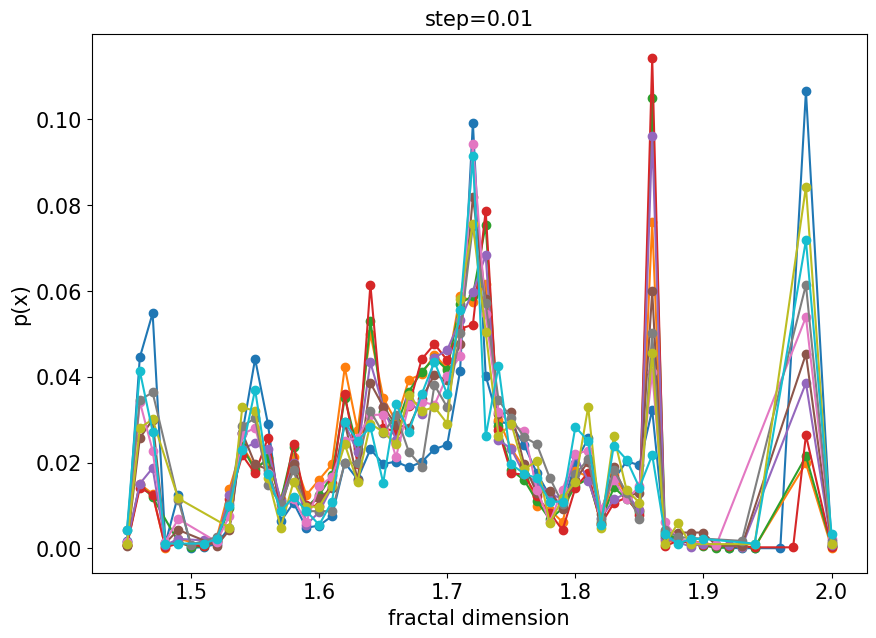

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 919/919 [00:00<00:00, 1189.44it/s]


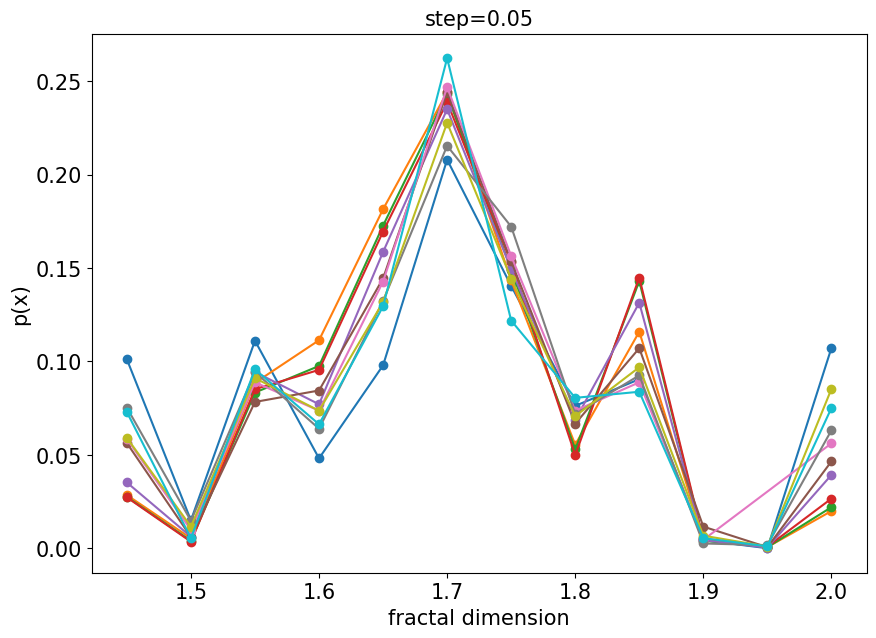

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 919/919 [00:00<00:00, 1202.99it/s]


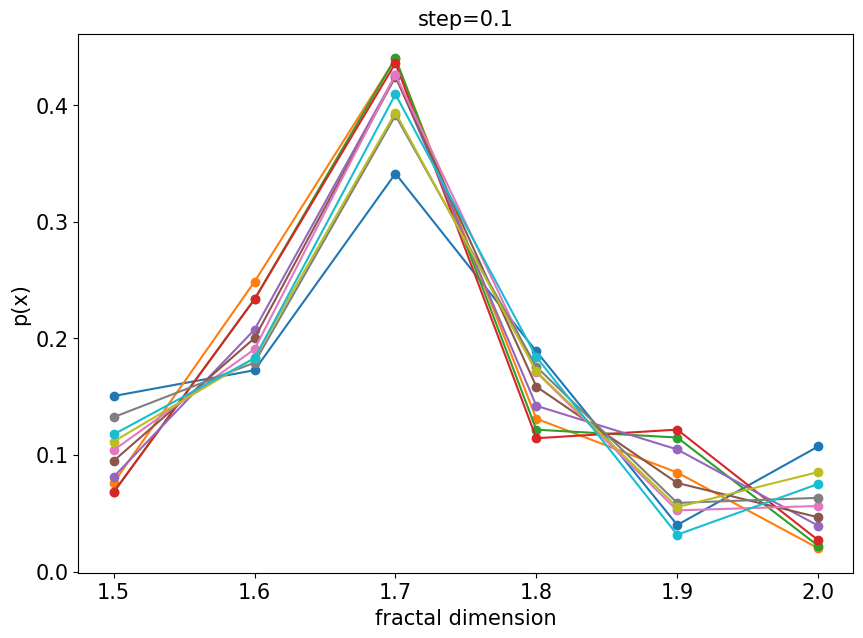

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 919/919 [00:00<00:00, 1238.14it/s]


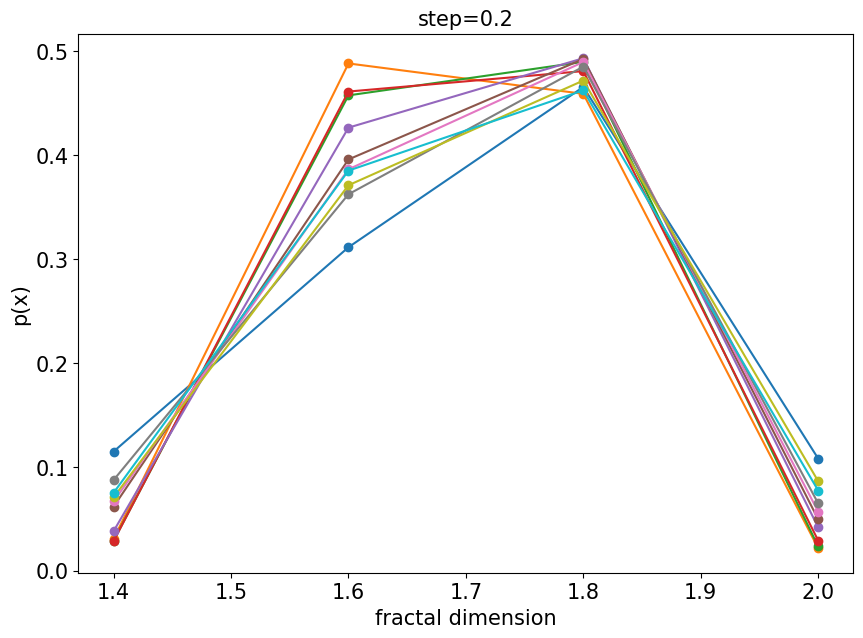

CPU times: user 7.43 s, sys: 3.79 s, total: 11.2 s
Wall time: 1min 52s


In [5]:
%%time

def process_contour(contour_idx):
    ## global var!!!!!

    contour = contours[contour_idx]

    eps=3
    x_min,y_min=np.min(contour,axis=0)[0]

    cnt_new = copy.copy(contour)
    cnt_new[:,:,0]=np.int32(cnt_new[:,:,0]-x_min+eps)
    cnt_new[:,:,1]=np.int32(cnt_new[:,:,1]-y_min+eps)

    x_max,y_max=np.max(cnt_new,axis=0)[0]

    mask = np.zeros((x_max+eps,y_max+eps))
    cv2.drawContours(mask, [cnt_new], -1, 255, thickness=cv2.FILLED)

    analyzer = StereoFractAnalyzer()

    sizes, counts = analyzer.box_count_image(Image.fromarray(np.uint8(cm.gist_earth(mask)*255)))
    log_sizes = np.log(1/sizes)
    log_counts = np.log(counts)
    coeffs = np.polyfit(log_sizes, log_counts, 1)
    fractal_dimension = coeffs[0]

    return fractal_dimension

images_paths=['images/0005.JPG',
              'images/0500.JPG',
              'images/1000.JPG',
              'images/1500.JPG',
              'images/2000.JPG',
              'images/2500.JPG',
              'images/3000.JPG',
              'images/3500.JPG',
              'images/4000.JPG',
              'images/4321.JPG',
              ]

legend=[]

for step in [0.01,0.05,0.1,0.2]:

    plt.figure(figsize=(10,7))

    for image_path in tqdm(images_paths):
        binary, contours = preprocess_image(image_path)

        # Prepare data
        new_contours=[contour for contour in contours if len(contour)>2]

        indices = list(range(len(new_contours)))

        # Process in parallel - NO shared_objects
        fds = []
        with WorkerPool(n_jobs=10) as pool:
            results = pool.map(process_contour, indices, progress_bar=True)
            fds = [fd for fd in results if fd is not None]

        x, y = combra_stats.stats_preprocess(fds, step)
        plt.plot(x, y, '-o')

        legend.append(f'{len(contours)} contours {image_path.split("/")[-1]}')


    # plt.legend(legend, loc='upper right',fontsize=15)
    # plt.xlim(0,40)
    # plt.xscale('log')
    # plt.yscale('log')
    plt.xlabel('fractal dimension',fontsize=15)
    plt.ylabel('p(x)',fontsize=15)
    plt.title(f'step={step}',fontsize=15)

    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    # plt.savefig(f'fractal_dimension={step}.jpg',bbox_inches='tight')

    plt.show()